This is a notebook to generate mfcc features for audio, features will be save to a binary file.

In [42]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import hashlib
import math, time, datetime
import os.path
import random
import re
import sys
import tarfile

import matplotlib.pyplot as plt
import numpy as np
import librosa as rosa
import librosa.display
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import numpy as np
from sklearn import preprocessing

default_number_of_mfcc=128
default_sample_rate=16000
default_hop_length=512 
default_wav_duration=1 # 1 second
default_validation_percentage=0.01
default_train_samples=10000
default_validation_samples=100
default_test_samples=100
#default_wanted_words=["one", "two", "bed", "backward", "bird", "cat", "dog", "eight", "five", "follow", "forward", "four", "go", "happy", "house", "learn", "left", "marvin", "nine", "no", "off", "right", "seven", "sheila", "stop", "three", "tree", "visual", "wow", "zero","up"]
#default_train_words=["one", "two", "cat", "dog", "bed", "backward", "eight","forward", "four", "go", "happy", "house", "learn", "left", "marvin", "nine", "no", "off", "right", "seven", "sheila", "stop", "three", "tree", "visual", "wow", "zero","up"]
#default_test_words=["five", "follow", "bird"]

#STUB start
default_wanted_words=["stub1", "stub2"]
default_train_words=["stub1", "stub2"]
default_test_words=["stub2"]
default_validation_percentage=0.5
#STUB end

#for linux
speech_data_dir="/home/zhangjun/tensorflow/speech_siamese_zj/speech_dataset"

#for windows
#speech_data_dir="D:\jun\speech_commands-master\dataset"

# One shot keyword trigger


Here is another implementation of one-shot learning of keyword trigger with librosa mfcc. 
librosa cannot put into tensorflow graph. so mfcc computation will be done before conv network. 
that means load_wav_mfcc has to convert all wav file to mfcc vector. 
Here i have to understand
    1, what is the good mfcc vector dimension. 20, 127 may not be the right input for conv network. 
    2, even the mfcc output of librosa is not the same as tensorflow contrib.decode wav, it is enough if it has all audio feature. put librosa mfcc output as input of conv net, it will do good learning about feature abstraction. 
    3, conv net may not be that difficult. just like conv2d -> maxpooling -> conv2d->flatten->dense with softmax. 
    4, build the train network with librosa and conv net.
    5, take the dense vector output as feature extractor. 
    6, build siamese network with the feature extractor. 
    7, may add couples of dense layer to learn the feature mapping and comparation of siamese. 
    8, if that works, we get an one-shot learning for key word trigger...
    9, in reality, we still have to work out how to split the audio stream into audio clip as the input the librosa mfcc.
    

### MFCC 

extract MFCC from wav file
what is the wav parameter for MFCC output

tensorflow speech command parameter 
{'desired_samples': 16000, 'window_size_samples': 480, 'window_stride_samples': 160, 'spectrogram_length': 98, 'fingerprint_width': 40, 'fingerprint_size': 3920, 'label_count': 12, 'sample_rate': 16000, 'preprocess': 'mfcc', 'average_window_width': -1}

Mel-frequency cepstral coefficients (MFCCs)
Parameters:	
y:np.ndarray [shape=(n,)] or None
audio time series
sr:number > 0 [scalar]
sampling rate of y
S:np.ndarray [shape=(d, t)] or None
log-power Mel spectrogram
n_mfcc: int > 0 [scalar]
number of MFCCs to return
Returns:	
M:np.ndarray [shape=(n_mfcc, t)]
MFCC sequence

need more study about MFCC output


## How to calculate the lenght of mfcc vector
Short Answer

You can specify the change the length by changing the parameters used in the stft calculations. The following code will double the size of your output (20 x 113658)

data = librosa.feature.mfcc(y=y, sr=sr, n_fft=1012, hop_length=256, n_mfcc=20)
Long Answer

Librosa's librosa.feature.mfcc() function really just acts as a wrapper to librosa's librosa.feature.melspectrogram() function (which is a wrapper to librosa.core.stft and librosa.filters.mel functions).

All of the parameters pertaining to segementation of the audio signal - namely the frame and overlap values - are specified utilized in the Mel-scaled power spectrogram function (with other tune-able parameters specified for nested core functions). You specify these parameters as keyword arguments in the librosa.feature.mfcc() function.

All extra **kwargs parameters are fed to librosa.feature.melspectrogram() and subsequently to librosa.filters.mel()

By Default, the Mel-scaled power spectrogram window and hop length are the following:

n_fft=2048

hop_length=512

So assuming you used the default sample rate (sr=22050), the output of your mfcc function makes sense:

output length = (seconds) * (sample rate) / (hop_length)

(1319) * (22050) / (512) = 56804 samples


the mfcc vector size is 128 * 32   

1 * 16000/512 = 31.25 = 32 

In [43]:
def load_wav_mfcc(filename):
    wav_loader, sample_rate = rosa.load(filename, sr=default_sample_rate)
    #print(rosa.get_duration(wav_loader, sample_rate))
    wav_mfcc = rosa.feature.mfcc(y=wav_loader, sr=default_sample_rate, n_mfcc=default_number_of_mfcc)
    wav_mfcc = np.transpose(wav_mfcc)
    return wav_mfcc

def get_default_mfcc_length(default_wav_duration=1):
    length = int(math.ceil(default_wav_duration * default_sample_rate / default_hop_length))
    return length

def mfcc_display(mfccs):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()

# Wav MFCC loader
Wav file loader and export mfcc sequence. 

0, go throught all wav file to add background voice into command wav file
1, go through all wav file and convert to MFCC sequence
2, construct pair of MFCC sequence and a target (0 or 1, 0 for different command, 1 for the same command)
    the same word * 1000, random generate key index, the first index of wav, and the second index of wav. 
    the diff word * 1000, random generae two key index, the first index of wav, and the second index of wav. 
    the format will be [mfcc 1, mfcc 2, 0/1 for the same or different]
3, prepare pair of MFCC and targets according to batch size.  

In [50]:
class WavMFCCLoader(object):
    def __init__(self, data_dir, wanted, mean=0, std=0):
        self.data_dir = data_dir
        self.wanted = wanted
        self.default_mfcc_length=get_default_mfcc_length(default_wav_duration)
        self.wav_files = dict()
        self.train_wav_files = dict()
        self.validation_wav_files = dict()
        self.wav_file_index()
        self.train_validation_wav_file_index()
        self.mfcc_mean = mean
        self.mfcc_std = std
        #print("train_wav_files:", self.train_wav_files)
        #print("validation_wav_files:", self.validation_wav_files)
        
    def wav_file_index(self):
        for dirpath, dirnames, files in os.walk(self.data_dir):
            for name in files:
                if name.lower().endswith('.wav'):
                    #for windows
                    #word_name = dirpath.rsplit('\\', 1)[1];
                    #for others
                    word_name = dirpath.rsplit('/', 1)[1];
                    if word_name in self.wanted:
                        file_name = os.path.join(dirpath, name)
                        #print(file_name, dirpath, word_name)
    
                        if word_name in self.wav_files.keys():
                            self.wav_files[word_name].append(file_name)
                        else:
                            self.wav_files[word_name] = [file_name]
                    
        return self.wav_files
    
    def train_validation_wav_file_index(self):
        for i in (self.wanted):
            wav_num = len(self.wav_files[i])
            wav_validation_num = int(wav_num * default_validation_percentage)
            wav_train_num = wav_num - wav_validation_num
            #print("wav_train_num:", wav_train_num)
            #print("wav_validation_num:", wav_validation_num)
            
            self.train_wav_files[i] = [self.wav_files[i][0]]
            self.validation_wav_files[i] = [self.wav_files[i][wav_train_num]]
            
            for j in range(1, wav_train_num):
                self.train_wav_files[i].append(self.wav_files[i][j])
                
            for j in range(wav_train_num + 1, wav_num):
                self.validation_wav_files[i].append(self.wav_files[i][j])
                
        return self.train_wav_files, self.validation_wav_files
    
    def wavs_to_mfcc_pair(self, wav_files = dict()):
        how_many_words = len(self.wanted)
        a_index = random.randint(0, how_many_words - 1)
        b_index = random.randint(0, how_many_words - 1)
 
        a_wav_index = b_wav_index = -1
        if (a_index > b_index):
            a_wav_index = random.randint(0, len(wav_files[self.wanted[a_index]]) - 1)
            b_wav_index = random.randint(0, len(wav_files[self.wanted[b_index]]) - 1)
            mfcc_1 = load_wav_mfcc(wav_files[self.wanted[a_index]][a_wav_index])
            mfcc_2 = load_wav_mfcc(wav_files[self.wanted[b_index]][b_wav_index])
            mfcc_pair = 0            
        else:
            a_wav_index = random.randint(0, len(wav_files[self.wanted[a_index]]) - 1)
            b_wav_index = random.randint(0, len(wav_files[self.wanted[a_index]]) - 1)
            mfcc_1 = load_wav_mfcc(wav_files[self.wanted[a_index]][a_wav_index])
            mfcc_2 = load_wav_mfcc(wav_files[self.wanted[a_index]][b_wav_index])
            mfcc_pair = 1
               
        return mfcc_1, mfcc_2, mfcc_pair
        
    def get_mfcc_pairs(self, how_many, period = "train", preprocess = "global"):
        mfcc1_data = np.zeros((how_many, self.default_mfcc_length, default_number_of_mfcc))
        mfcc2_data = np.zeros((how_many, self.default_mfcc_length, default_number_of_mfcc))
        same_data = np.zeros(how_many)
            
        for i in range(0, how_many):
            if period == "train":
                mfcc1_data_, mfcc2_data_, same_data[i] = self.wavs_to_mfcc_pair(wav_files = self.train_wav_files)
            elif period == "validate":
                mfcc1_data_, mfcc2_data_, same_data[i] = self.wavs_to_mfcc_pair(wav_files = self.validation_wav_files)
            elif period == "test":
                mfcc1_data_, mfcc2_data_, same_data[i] = self.wavs_to_mfcc_pair(wav_files = self.wav_files)
            else:
                raise ValueError("unknown period")
                       
            
            if preprocess == "global":
                mfcc1_data_ = (mfcc1_data_ - self.mfcc_mean[0:mfcc1_data_.shape[0], :]) / self.mfcc_std[0:mfcc1_data_.shape[0], :]
                mfcc2_data_ = (mfcc2_data_ - self.mfcc_mean[0:mfcc2_data_.shape[0], :]) / self.mfcc_std[0:mfcc2_data_.shape[0], :]
            elif preprocess == "z-score":
                mfcc1_data_ = preprocessing.scale(mfcc1_data_)
                mfcc2_data_ = preprocessing.scale(mfcc2_data_)               
            elif preprocess == "max-min-scaler":
                mfcc1_data_ = preprocessing.MinMaxScaler().fit_transform(mfcc1_data_)
                mfcc2_data_ = preprocessing.MinMaxScaler().fit_transform(mfcc2_data_)
            elif preprocess == "l2-normalize":
                mfcc1_data_ = preprocessing.normalize(mfcc1_data_, norm='l2')
                mfcc2_data_ = preprocessing.normalize(mfcc2_data_, norm='l2')
            else:
                raise ValueError("unknown proprocess")
                
            mfcc1_data[i, 0:mfcc1_data_.shape[0], : ] = mfcc1_data_
            mfcc2_data[i, 0:mfcc2_data_.shape[0], : ] = mfcc2_data_
    
        return mfcc1_data, mfcc2_data, same_data 
    
    def get_sample_mean_std(self):
        count = 0
        for i in (self.wanted):
            #print(i)
            for j in range(len(self.wav_files[i])):
                #print(self.wav_files[i][j])
                count += 1
        #print("count:", count)
        mfccs = np.zeros((count, self.default_mfcc_length, default_number_of_mfcc))
        index = 0
        for i in (self.wanted):
            for j in range(len(self.wav_files[i])):       
                mfcc_ = load_wav_mfcc(self.wav_files[i][j])
                mfccs[index, 0:mfcc_.shape[0], : ] = mfcc_
                index += 1
        print("mfccs.shape:", mfccs.shape)
        return mfccs.mean(0), mfccs.std(0)


mfccs.shape: (6, 32, 128)
mean shape: (32, 128)
std shape: (32, 128)


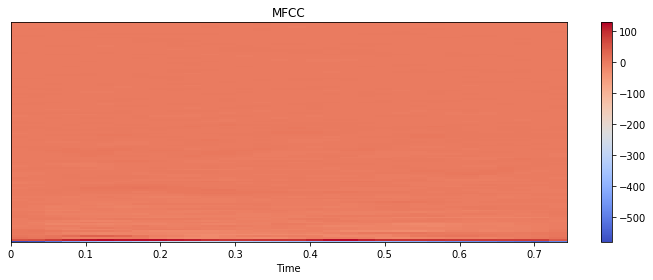

In [51]:
loader_1 = WavMFCCLoader(speech_data_dir, wanted=default_wanted_words)
mfcc_mean, mfcc_std = loader_1.get_sample_mean_std()
print("mean shape:", mfcc_mean.shape)
print("std shape:", mfcc_std.shape)
mfcc_display(np.transpose(mfcc_mean))

label: 0.0
label: 1.0
label: 1.0
label: 0.0
label: 1.0


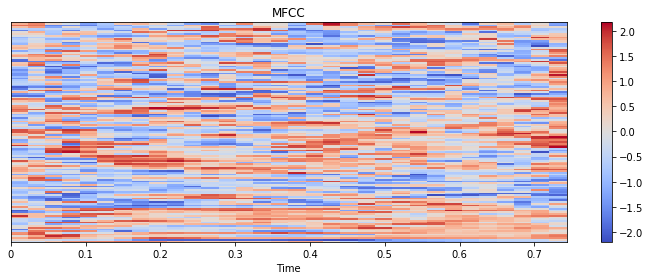

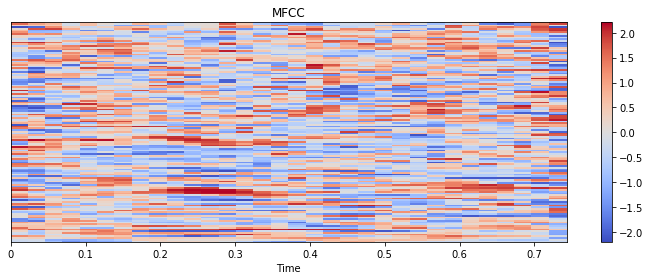

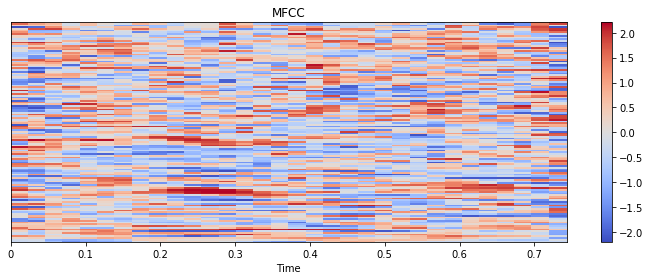

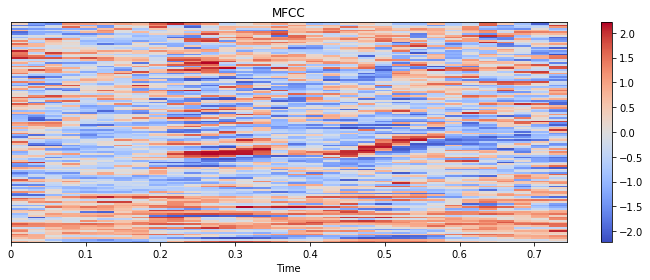

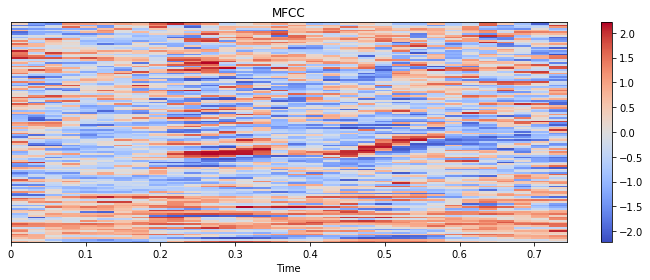

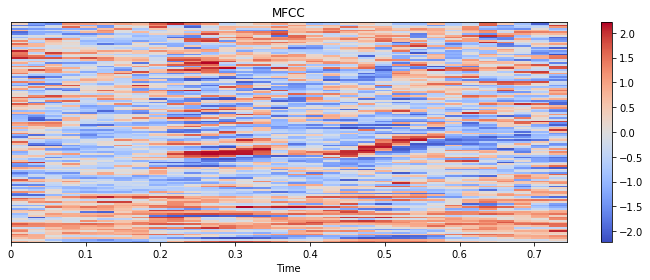

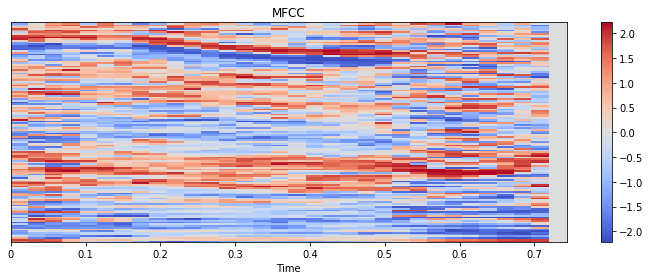

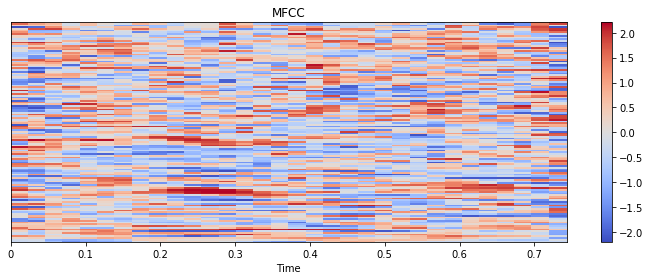

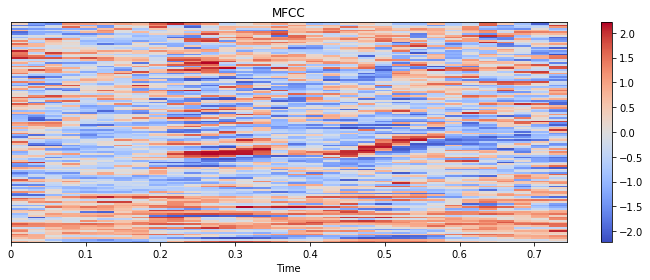

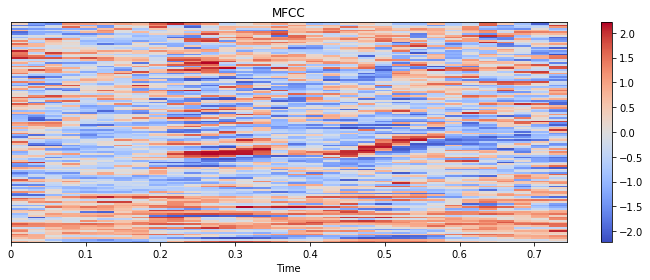

In [53]:
loader_2 = WavMFCCLoader(speech_data_dir, wanted=default_train_words, mean = mfcc_mean, std = mfcc_std)
mfcc1_train_global, mfcc2_train_global, same_train_global = loader_2.get_mfcc_pairs(5, period = "train", preprocess = "global")
for i in range(len(mfcc1_train_global)):
    mfcc_display(np.transpose(mfcc1_train_global[i]))
    mfcc_display(np.transpose(mfcc2_train_global[i]))
    print("label:", same_train_global[i])

label: 1.0
label: 1.0
label: 1.0
label: 0.0
label: 1.0


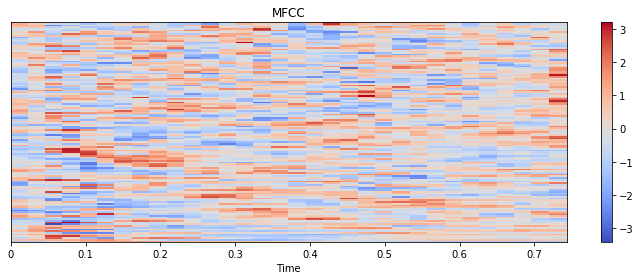

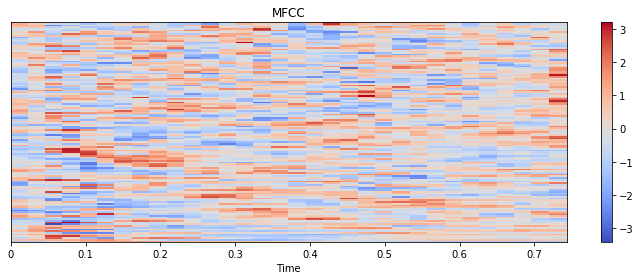

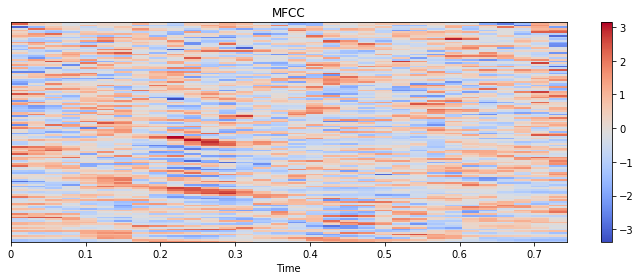

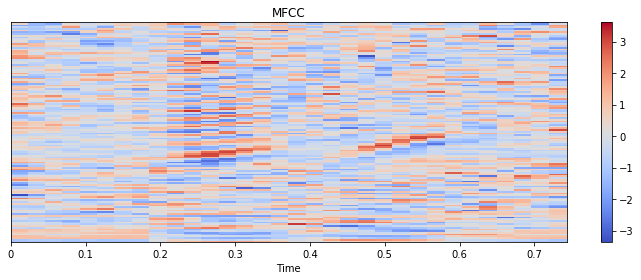

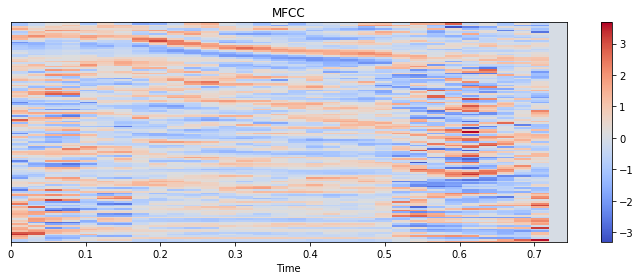

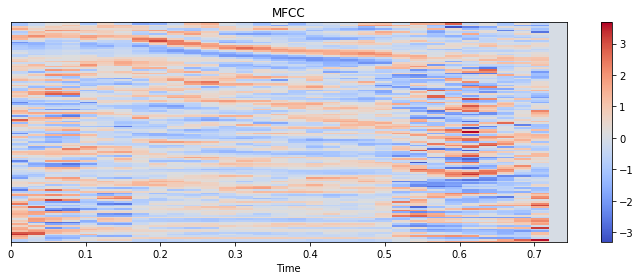

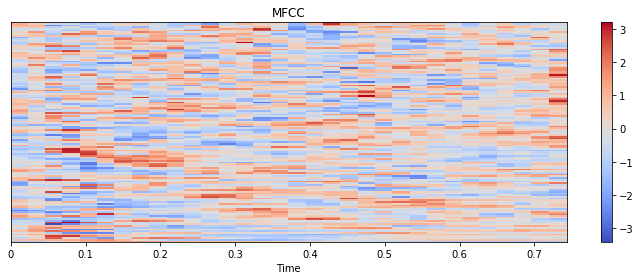

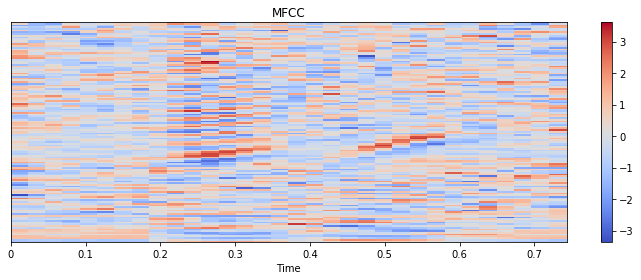

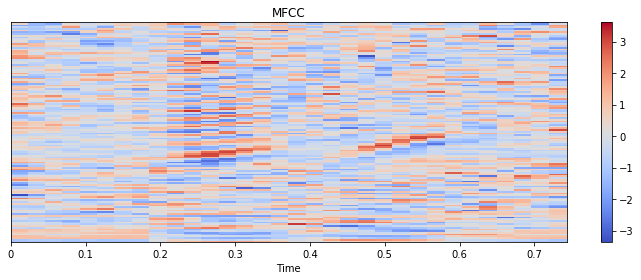

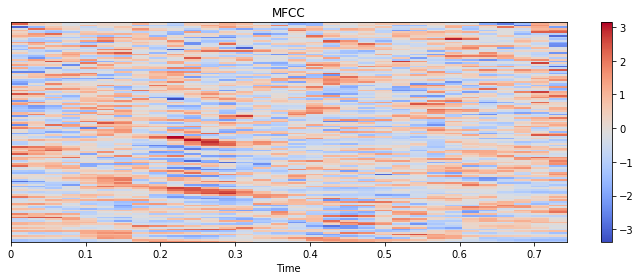

In [54]:
mfcc1_train_z, mfcc2_train_z, same_train_z = loader_2.get_mfcc_pairs(5, period = "train", preprocess = "z-score")
for i in range(len(mfcc1_train_z)):
    mfcc_display(np.transpose(mfcc1_train_z[i]))
    mfcc_display(np.transpose(mfcc2_train_z[i]))
    print("label:", same_train_z[i])

label: 1.0
label: 1.0
label: 1.0
label: 1.0
label: 1.0


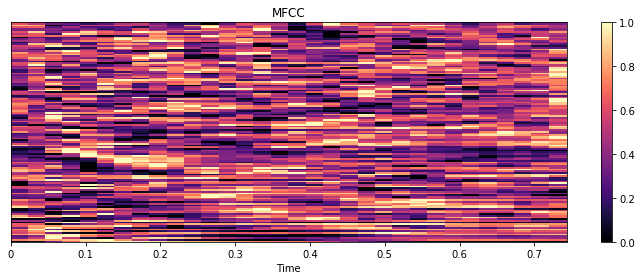

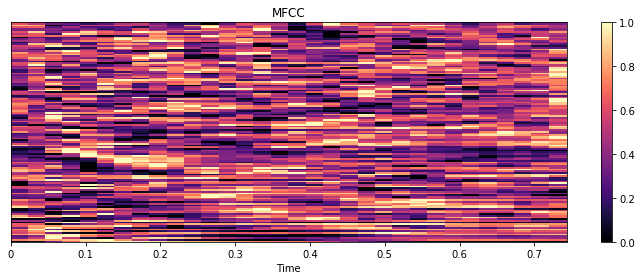

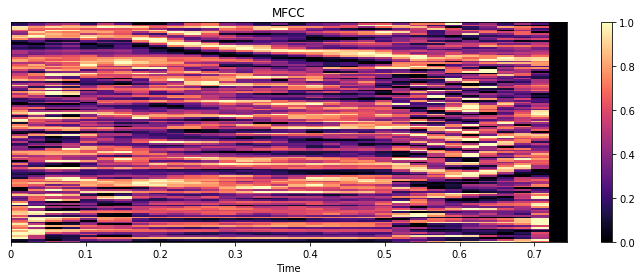

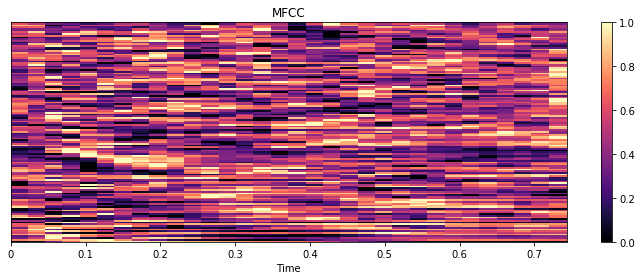

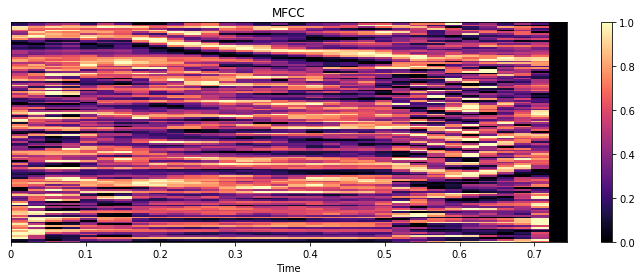

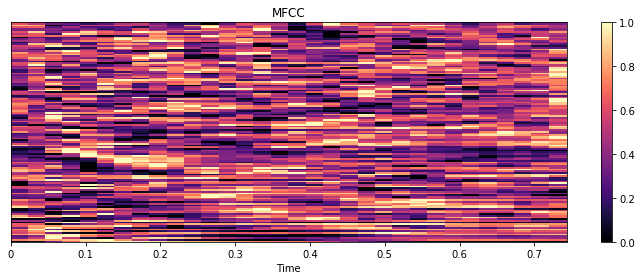

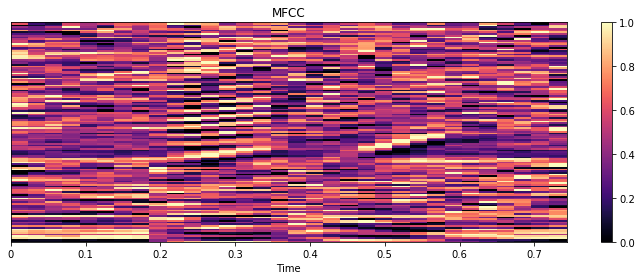

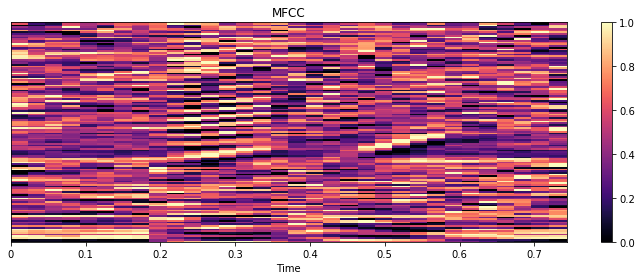

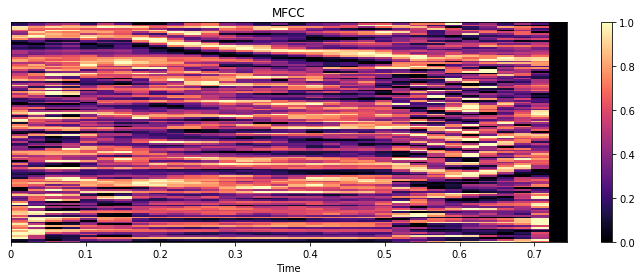

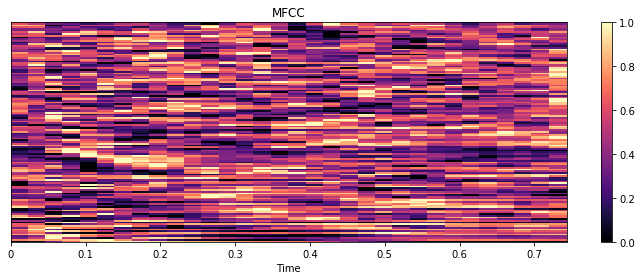

In [55]:
mfcc1_train_s, mfcc2_train_s, same_train_s = loader_2.get_mfcc_pairs(5, period = "train", preprocess = "max-min-scaler")
for i in range(len(mfcc1_train_s)):
    mfcc_display(np.transpose(mfcc1_train_s[i]))
    mfcc_display(np.transpose(mfcc2_train_s[i]))
    print("label:", same_train_s[i])

label: 1.0
label: 0.0
label: 1.0
label: 0.0
label: 1.0


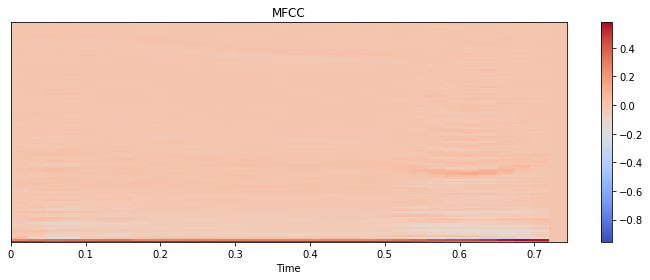

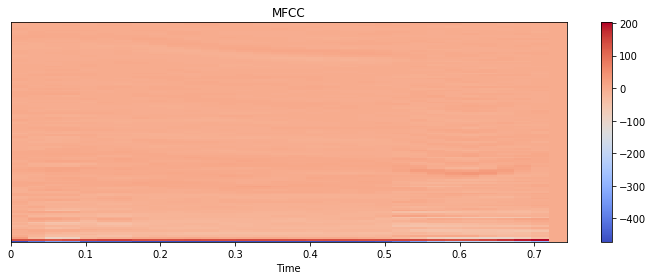

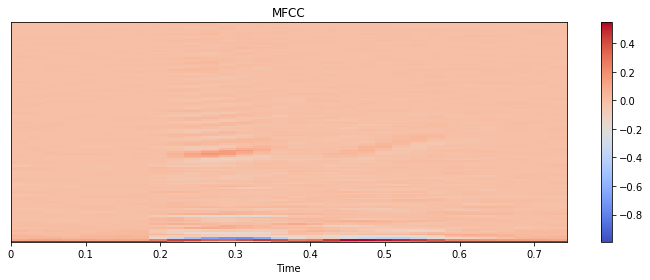

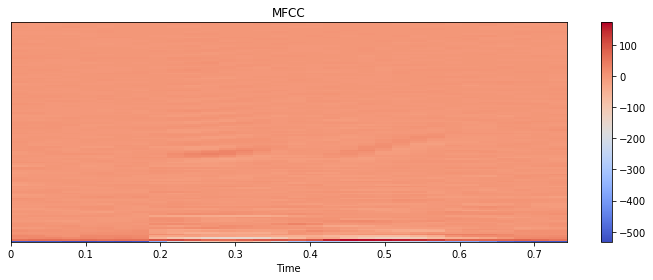

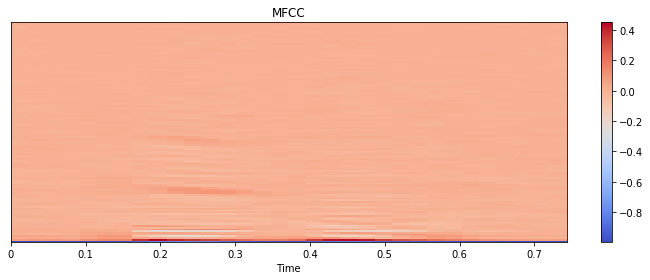

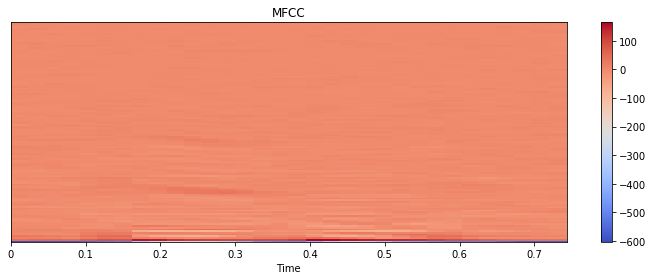

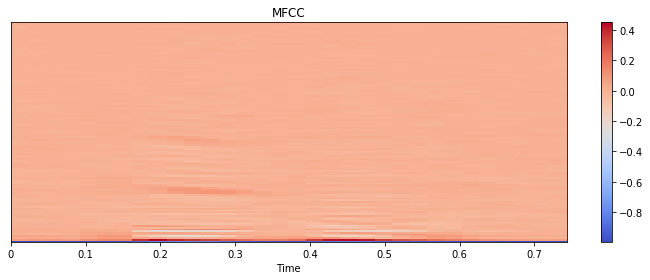

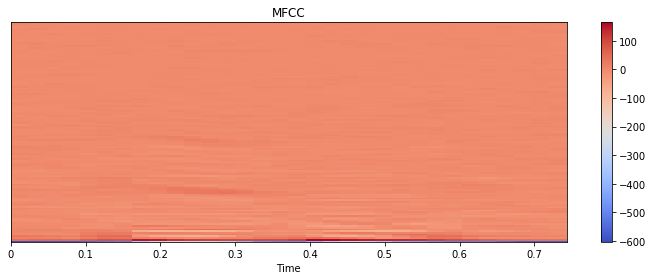

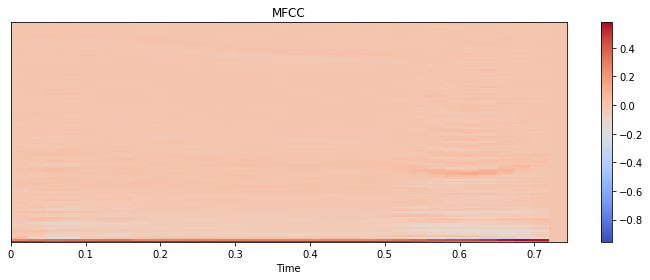

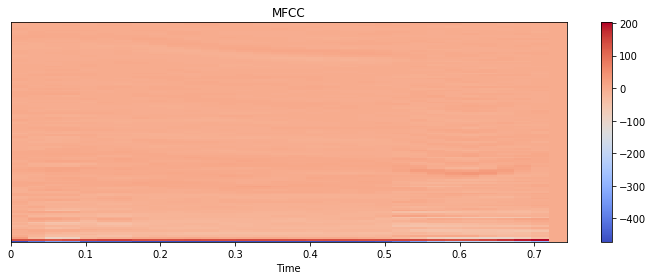

In [57]:
mfcc1_train_n, mfcc2_train_n, same_train_n = loader_2.get_mfcc_pairs(5, period = "train", preprocess = "l2-normalize")
for i in range(len(mfcc1_train_n)):
    mfcc_display(np.transpose(mfcc1_train_n[i]))
    mfcc_display(np.transpose(mfcc2_train_n[i]))
    print("label:", same_train_n[i])